In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import os

In [149]:
data_path = os.path.join('..', 'data')
results_path = os.path.join('..', 'results')
models_path = os.path.join('..', 'models')

df_alpha_beta = pd.read_csv(os.path.join(data_path, "dataset_alpha_betha.csv"))
df_demand = pd.read_csv(os.path.join(data_path, "dataset_demand_acumulate.csv"))
df_to_predict = pd.read_csv(os.path.join(data_path, "to_predict.csv"))

# Punto 1

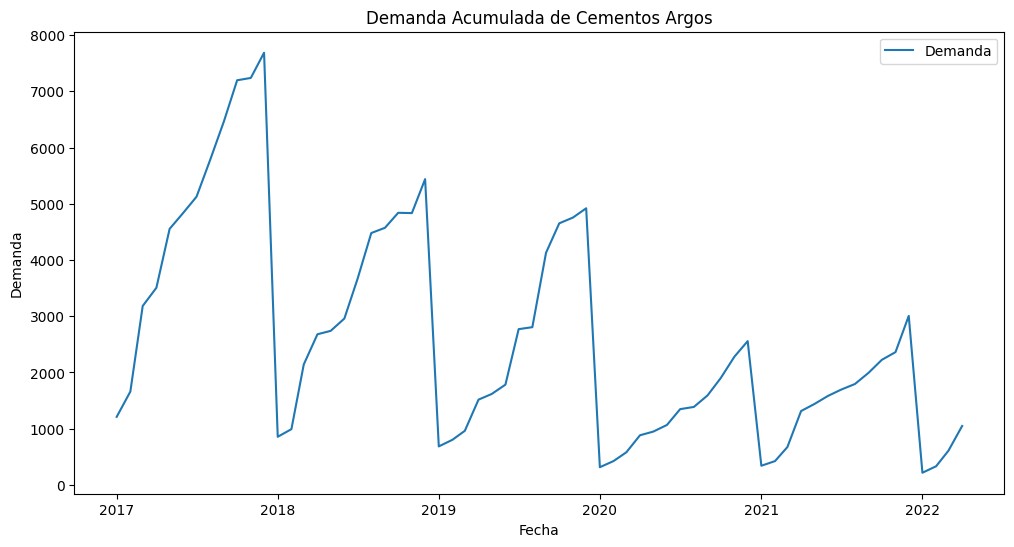

In [150]:
df_demand['year_month'] = pd.to_datetime(df_demand['year_month'], format='%Y-%m')
df_demand.set_index('year_month', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_demand.index, df_demand['Demand'], label='Demanda')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title('Demanda Acumulada de Cementos Argos')
plt.legend()
plt.show()

## Descomposición de la serie

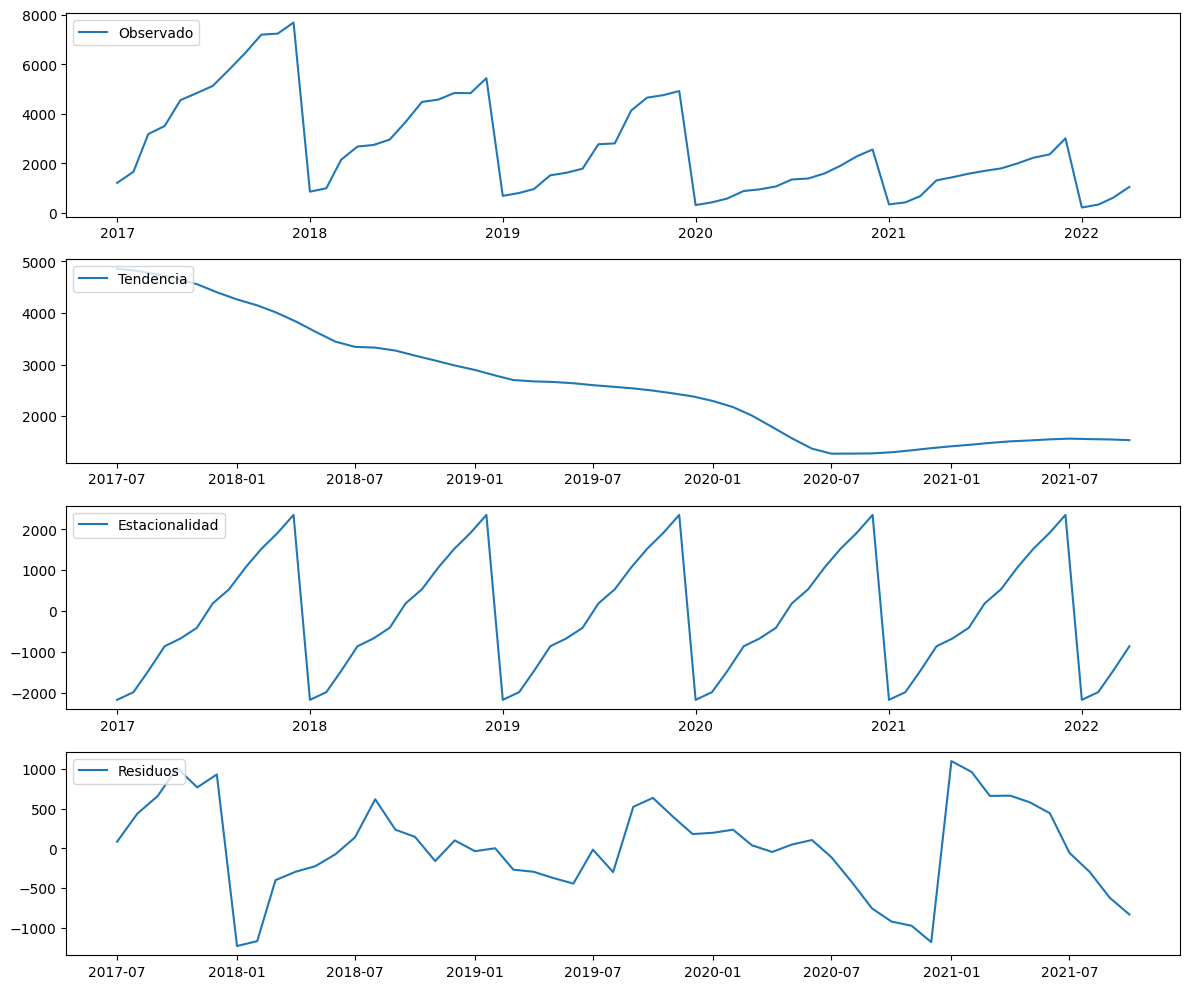

In [151]:
decomposition = seasonal_decompose(df_demand['Demand'], model='additive')

plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuos')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

- La serie observada muestra un patrón general con incrementos y caídas significativas. Esto indica fluctuaciones en la demanda a lo largo del tiempo.


- La tendencia muestra una disminución constante en la demanda hasta alrededor de mediados de 2020, después de lo cual parece estabilizarse y comenzar a aumentar ligeramente. Esto sugiere que hubo un periodo de declive en la demanda que luego se niveló.


- La componente estacional muestra un patrón repetitivo claro que se repite anualmente. Esto indica que hay factores estacionales que afectan la demanda, como variaciones durante diferentes épocas del año. El patrón estacional parece ser bastante consistente a lo largo de los años.

- Los residuos representan la parte de la serie que no puede ser explicada por la tendencia ni por la estacionalidad. Observamos que hay variaciones en los residuos, con algunos picos y valles pronunciados. Esto puede deberse a eventos inesperados o a variabilidad no capturada por los otros componentes.

Por medio del análisis gráfico, se detalla que la serie no es estacionaria en su media y varianza.

## Prueba Dicky Fuller aumentada

In [152]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_demand['Demand'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.441016
p-value: 0.000251


El test indica que la serie es estacionaria. Sin embargo, de acuerdo con el análisis gráfico se mencionaba la no estacionariedad. En consecuencia, se procede a realizar los respectivos ajustes de la serie a través de la transformación Box-Cox (estacionariedad en la varianza) y primeras diferencias (estacionariedad en la media).

## Transformación Box-Cox y primeras diferencias

Lambda de Box-Cox: 0.243909229593935


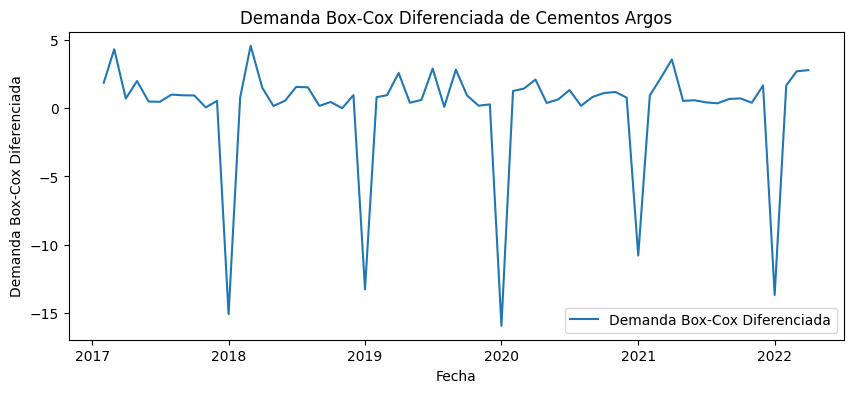

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller

df_demand['demand_boxcox'], lam = boxcox(df_demand['Demand'] + 1)
print(f"Lambda de Box-Cox: {lam}")

# Primeras diferencias
df_demand['demand_boxcox_diff'] = df_demand['demand_boxcox'].diff()
df_demand.dropna(inplace=True)

# Plot series
plt.figure(figsize=(10, 4))
plt.plot(df_demand.index, df_demand['demand_boxcox_diff'], label='Demanda Box-Cox Diferenciada')
plt.xlabel('Fecha')
plt.ylabel('Demanda Box-Cox Diferenciada')
plt.title('Demanda Box-Cox Diferenciada de Cementos Argos')
plt.legend()
plt.show()

Tras realizar la transformación Box-Cox y sacar las primeras diferencias, se observa que la serie es más estable, resaltandose los picos asociados a un claro factor estacional.

## Autocorrelación y Autocorrelación Parcial 

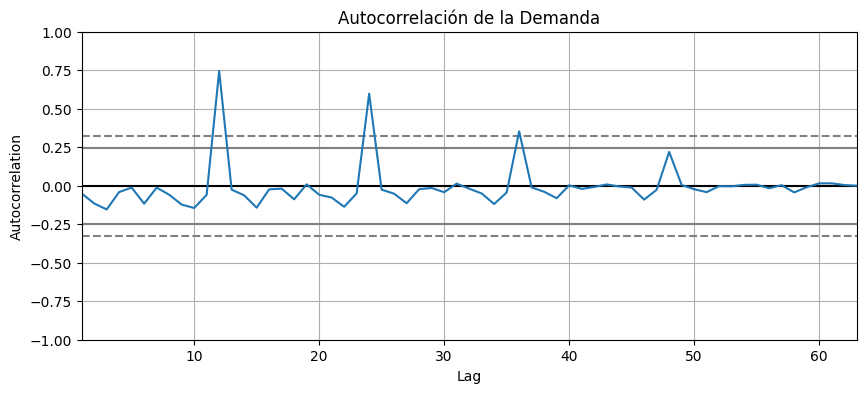

<Figure size 1000x600 with 0 Axes>

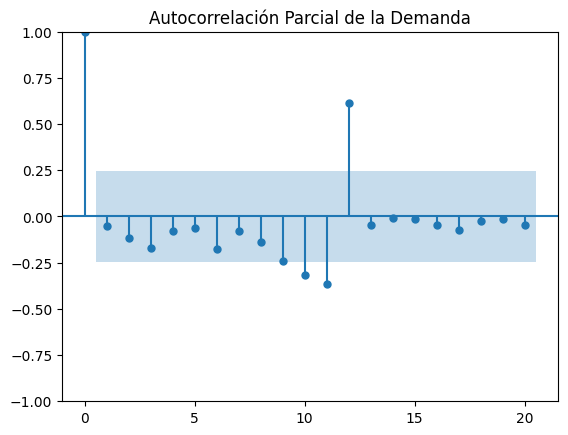

In [154]:
# Autocorrelación
plt.figure(figsize=(10, 4))
pd.plotting.autocorrelation_plot(df_demand['demand_boxcox_diff'])
plt.title('Autocorrelación de la Demanda')
plt.show()


# Autocorrelación parcial
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10, 6))
plot_pacf(df_demand['demand_boxcox_diff'], lags=20)
plt.title('Autocorrelación Parcial de la Demanda')
plt.show()

El gráfico de autocorrelación (ACF) muestra picos significativos en los retrasos (lags) de aproximadamente 12 y 24 periodos, indicando una fuerte correlación positiva en esos puntos. Esto sugiere una estacionalidad clara en la demanda, con un patrón repetitivo aproximadamente cada 12 periodos. Los picos fuera de los intervalos de confianza refuerzan la presencia de esta estacionalidad, lo que implica que la demanda tiene un comportamiento cíclico regular.

El gráfico de autocorrelación parcial (PACF) muestra una autocorrelación significativa en el primer retraso, sugiriendo que un modelo AR(1) podría ser adecuado para capturar la estructura de la serie temporal. Además, el pico significativo en el retraso 12 refuerza la presencia de estacionalidad observada en el ACF, indicando la necesidad de considerar componentes estacionales en el modelo. Los resultados sugieren la utilidad de un modelo SARIMA para capturar tanto los patrones estacionales como los autorregresivos de la demanda.

Con base en estos gráficos, un modelo ARIMA o SARIMA sería adecuado para capturar tanto los componentes de tendencia como de estacionalidad.

## Implementación de modelo SARIMA

In [155]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# SARIMA config
p = 1  # lags PACF
d = 0  # Diff
q = 1  # lags ACF

# SARIMA model
model = SARIMAX(df_demand['demand_boxcox_diff'], order=(p, d, q), seasonal_order=(p, d, q, 12))
model_fit = model.fit(disp=False)

# Data split
train = df_demand[:'2021-06']
test = df_demand['2021-07':]

# Forecast
forecast_boxcox_diff = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
test['Forecast'] = forecast_boxcox_diff

# Invertir la diferenciación para obtener los valores Box-Cox
last_value_boxcox = train['demand_boxcox'].iloc[-1]
test['Forecast_BoxCox'] = forecast_boxcox_diff.cumsum() + last_value_boxcox

# Invertir la transformación de Box-Cox para obtener los valores originales
test['Forecast_Original'] = inv_boxcox(test['Forecast_BoxCox'], lam) - 1

# Df Plot
combined = pd.concat([train[['demand_boxcox']], test[['demand_boxcox', 'Forecast_Original']]], axis=0)
combined['demand_original'] = inv_boxcox(combined['demand_boxcox'], lam) - 1
combined['Dataset'] = 'Entrenamiento'
combined.loc[test.index, 'Dataset'] = 'Test'
combined.loc[test.index, 'Forecast_Original'] = inv_boxcox(test['Forecast_BoxCox'], lam) - 1
combined.reset_index(inplace=True)

# Metricas de evaluación
rmse_original = mean_squared_error(test['Demand'], test['Forecast_Original'], squared=False)
mae_original = mean_absolute_error(test['Demand'], test['Forecast_Original'])
r2_original = r2_score(test['Demand'], test['Forecast_Original'])

# Plot
fig = px.line(combined, x='year_month', y='demand_original', color='Dataset', labels={'demand_original': 'Demanda', 'year_month': 'Fecha'}, title='Pronóstico de Demanda')
fig.update_layout(legend_title_text='')
fig.add_scatter(x=test.index, y=test['Forecast_Original'], mode='lines', name='Pronóstico', line=dict(dash='dash'))
fig.add_annotation(x=0.99, y=0.99, xref='paper', yref='paper',
                   text=f'RMSE: {rmse_original:.2f}<br>MAE: {mae_original:.2f}<br>R2: {r2_original:.2f}',
                   showarrow=False, borderwidth=0)
fig.show()

# Forecast results
future_forecast_boxcox_diff = model_fit.predict(start='2022-05-01', end='2022-07-01', dynamic=False)
future_forecast_boxcox = future_forecast_boxcox_diff.cumsum() + test['Forecast_BoxCox'].iloc[-1]
future_forecast = inv_boxcox(future_forecast_boxcox, lam) - 1  # Restar 1 para volver a la escala original
print(f'Pronóstico para mayo, junio y julio de 2022: \n{future_forecast}')

Pronóstico para mayo, junio y julio de 2022: 
2022-05-01    722.618558
2022-06-01    766.091077
2022-07-01    944.638843
Freq: MS, Name: predicted_mean, dtype: float64


In [156]:
forecast_values = list(future_forecast)

## Análisis de residuos

In [157]:
from scipy.stats import shapiro, jarque_bera
test['Residuals'] = test['Demand'] - test['Forecast_Original']
stat, p = shapiro(test['Residuals'])
print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('La muestra parece normal (no se rechaza la hipótesis nula)')
else:
    print('La muestra no parece normal (se rechaza la hipótesis nula)')

Shapiro-Wilk Test: Statistics=0.921, p=0.363
La muestra parece normal (no se rechaza la hipótesis nula)


In [158]:
stat, p = jarque_bera(test['Residuals'])
print('Jarque-Bera Test: Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('La muestra parece normal (no se rechaza la hipótesis nula)')
else:
    print('La muestra no parece normal (se rechaza la hipótesis nula)')

Jarque-Bera Test: Statistics=0.666, p=0.717
La muestra parece normal (no se rechaza la hipótesis nula)


# Punto 2

In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score

In [160]:
#(df_alpha_beta == ' ').sum()
df_alpha_beta.replace(' ', np.nan, inplace=True)
df_alpha_beta['Demand'] = df_alpha_beta['Demand'].astype(float)
df_alpha_beta['Demand'].fillna(df_alpha_beta['Demand'].median(), inplace=True)

In [161]:
df_alpha_beta['Class'] = df_alpha_beta['Class'].map({'Alpha': 1, 'Betha': 0})

X = df_alpha_beta.drop(columns=['Class', 'autoID'])
y = df_alpha_beta['Class']

categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numeric_cols),
        ('cat', Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))]), categorical_cols)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

# Reducción de dimensionalidad con TruncatedSVD
svd = TruncatedSVD(n_components=10)
X_svd = svd.fit_transform(X_preprocessed)

preprocessor_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('svd', svd)])

# Balanceo de datos
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X_svd, y)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Entrenamiento del modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# Guardar metricas
with open(os.path.join(results_path, "classification_metrics.txt"), 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(f'Classification Report:\n{report}')
    f.write(f'Number of Training Samples: {len(y_train)}\n')
    f.write(f'Number of Test Samples: {len(y_test)}\n')
    f.write(f'Model: RandomForestClassifier\n')

Accuracy: 0.8222222222222222
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1049
           1       0.84      0.79      0.81      1021

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070



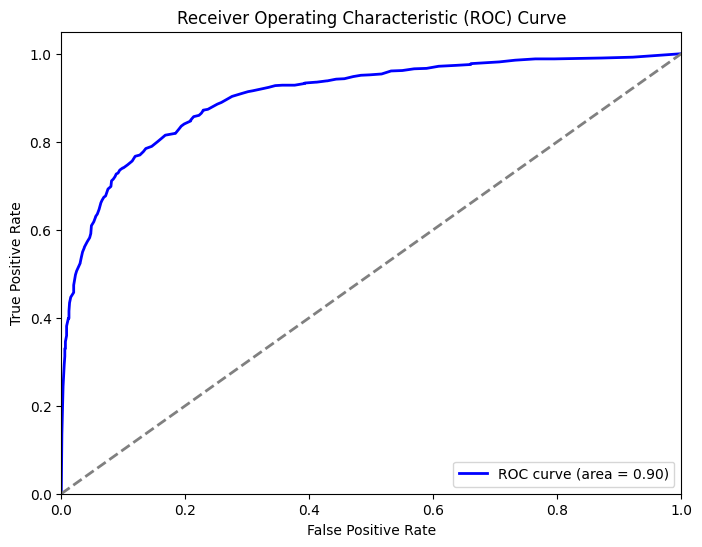

In [163]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [164]:
# Save model
joblib.dump(model, os.path.join(models_path, "classification_model.pkl"))
joblib.dump(preprocessor_pipeline, os.path.join(models_path, "preprocessor.pkl"))

['..\\models\\preprocessor.pkl']

# Punto 3

In [165]:
import requests
import pandas as pd

df_to_predict['Demand'] = forecast_values
df_to_predict = df_to_predict.drop(columns=['Class'])

# API
url = 'http://127.0.0.1:5000/predict'


results = pd.DataFrame(columns=['SeniorCity', 'Partner', 'Dependents', 'Service1', 'Service2', 
                                'Security', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                                'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges', 
                                'Demand', 'Prediction', 'Probability'])

for index, row in df_to_predict.iterrows():
    data = row.to_dict()
    response = requests.post(url, json=data)
    
    if response.status_code == 200:
        response_json = response.json()
        prediction = response_json['prediction']
        probability = response_json['probability']
        
        #  1: 'Alpha' ; 0: 'Betha'
        data['Prediction'] = 'Alpha' if prediction == 1 else 'Betha'
        data['Probability'] = probability
        results = pd.concat([results, pd.DataFrame([data])], ignore_index=True)
    else:
        print(f"Error en la solicitud HTTP: {response.status_code}")
        print(response.text)

# Save
results.to_csv(os.path.join(results_path, "prediction_results.csv"), index=False)